In [1]:
# do all the needed imports
import pandas as pd
import json
import random
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, auc, f1_score
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.spatial as sp
import tensorflow_hub as hub
import tensorflow as tf
import abc
from typing import List
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import csv

In [2]:
#get file paths
tweet_file='/content/cleaned_tweets - cleaned_tweets.csv'
tweetClass_file='/content/with_class_cleaned_tweets - with_class_cleaned_tweets.csv'

In [3]:
tweets = pd.read_csv(tweet_file)
tweetsClass=pd.read_csv(tweetClass_file)

In [4]:
print(len(tweets))
print(len(tweetsClass))

35675
29692


In [5]:
#remove extra columns
tweetsClass.drop(tweetsClass.iloc[:, 5:], inplace = True, axis = 1)
tweetsClass.drop(['tweetsORG','Hashtags'], inplace=True, axis=1)
#remove unannotated rows
tweetsClass.dropna(subset = ['Annotation'], inplace=True)

In [6]:
tweetsClass

,cleanTweets,Class,Annotation
0,I recently took my young child to have blood d...,Common Procedures,relevant
1,I was gonna tweet this out the other daythinki...,Common Procedures,irrelevant
2,Yes we are agree will fight until last drop of...,Common Procedures,irrelevant
3,NaN,Common Procedures,irrelevant
4,Insult and attack me all you want. I don't car...,Common Procedures,irrelevant
...,...,...,...
21089,"As part of our broad industrial strategy, Work...",Treatment,irrelevant
21090,The Oregon Capacity System enables healthcare ...,Treatment,irrelevant
21091,"First when it dropped, and then again a while ...",Treatment,irrelevant
21092,Reminder: Next Friday (20th) we have our works...,Treatment,irrelevant


In [7]:
#remove extra columns
tweets.drop(tweets.iloc[:, 5:], inplace=True, axis=1)
tweets.drop(['tweetsORG','tweetID', 'Hashtags' ], inplace=True, axis=1 )
#add class column
Nan=np.nan
tweets.insert(1, 'Class', value=Nan)
#remove unannotated rows
tweets.dropna(subset = ['Annotation'], inplace=True)

In [8]:
tweets

,cleanTweets,Class,Annotation
0,: It is always nice when the CT and OGD correl...,NaN,irrelevant
1,"mohali: Mohali blast: Babbar Khalsa, gangsters...",NaN,irrelevant
2,Polycystic Kidney Disease Symptoms..,NaN,irrelevant
3,"""Since Rand Paul (R-Moscow) just unilaterally ...",NaN,irrelevant
4,": Gareth, aged , is the first Australian to re...",NaN,relevant
...,...,...,...
994,Could you please share the AWB number via DM s...,NaN,irrelevant
995,: Annual routine of Siddharth Colony freeloade...,NaN,irrelevant
996,: You can acknowledge one persons emotional re...,NaN,irrelevant
997,"UAE President, Sheikh Khalifa bin Zayed Al-Nah...",NaN,irrelevant


In [9]:
print(len(tweets))
print(len(tweetsClass))

993
292


In [10]:
#final data with annotations
data = pd.concat([tweets, tweetsClass], axis=0) 
data.drop_duplicates(subset="cleanTweets", inplace=True)
data.dropna(subset = ['cleanTweets'], inplace=True)

In [42]:
len(data)

1283

In [43]:
# split data into train and test
train, test = train_test_split(data, test_size=0.2, random_state=42)
# let's select some sample from train set 
initial_train = train.sample(frac=0.05, random_state=42)
initial_train.reset_index(drop=True, inplace=True)
# and create our unlabelled pool
pool = train[~train.index.isin(initial_train.index)]
pool.reset_index(drop=True, inplace=True)

In [45]:
print("pool: ", len(pool), "initial train: ", len(initial_train))

pool:  946 initial train:  51


In [46]:
class QueryStrategy(abc.ABC):
    @abc.abstractmethod
    def selection(self, *args, **kwargs):
        raise NotImplementedError

In [47]:
class RandomSelection(QueryStrategy):
    """
    Random selection strategy.

    Parameters:
    probs: int - number of data samples in unlabelled pool
    num_samples: int - number of samples which we want to select

    Returns:
    List[int]: List of data samples indexes which will be selected.
    """
    def selection(self, probs: np.ndarray, num_samples: int) -> List[int]:
        if probs.shape[0] >= num_samples:
            selection = np.random.choice(probs.shape[0], num_samples, replace=False)
        else:
            selection = np.arange(probs.shape[0])
        return selection

In [48]:
class MarginSelection(QueryStrategy):
    """
    Margin selection strategy.

    Parameters:
    probs: np.ndarray - predicted probabilities of the unlabelled pool
    num_samples: int - number of samples which we want to select

    Returns:
    List[int]: List of data samples indexes which will be selected.
    """
    def selection(self, probs: np.ndarray, num_samples:int) -> List[int]:
        rev = np.sort(probs, axis=1)[:, ::-1]
        values = rev[:, 0] - rev[:, 1]
        if len(probs) >= num_samples:
            selection = np.argsort(values)[:num_samples]
        else:
            selection = np.argsort(values)
        return selection

In [49]:
class MostErrorBucketSelection(QueryStrategy):
    """
    Select from the specific range of the predicted probabilities, which contains the most amount of errors.

    Parameters:
    probs: np.ndarray - predicted probabilities of the unlabelled pool
    num_samples: int - number of samples which we want to select
    train: pd.Dataframe - train
    clf - classificator

    Returns:
    List[int]: List of data samples indexes which will be selected.
    """
    def selection(self, probs: np.ndarray, num_samples: int, train_: pd.DataFrame, clf):
        train_["probs"] = clf.predict_proba(train_["cleanTweets"])[:, 1]
        train_["decile"] = pd.cut(train_["probs"], 10)
        train_["preds"] = clf.predict(train_["cleanTweets"])
        train_["error"] = train_.apply(lambda x: 1 if x["preds"] != x["Annotation"] else 0, axis=1)
        train_["num_errors"] = train_.groupby("decile")["error"].transform(lambda x: x.sum())
        error_inter = train_.iloc[train_["num_errors"].argmax()]["decile"]
        mask = np.array([True if a in error_inter else False for a in probs[:, 1]])
        selection = mask.argsort()[-num_samples:]
        return selection

In [50]:
from typing import Callable, List, Any
from sklearn.metrics import f1_score
import inspect


class ActiveLearner:
    def __init__(self, test: pd.DataFrame, initial_train:pd.DataFrame, pool:pd.DataFrame,
                 classifier, batch_size: int = 10):
        self.batch_size: int = batch_size
        self.test: pd.DataFrame = test # test set
        self.train: pd.DataFrame = initial_train.copy() # train set
        self.pool: pd.DataFrame = pool.copy() # unlabeled pool
        self.classifier = classifier # classifier
        self.classifier.fit(self.train["cleanTweets"], self.train["Annotation"]) # fitting the classifier on initial train set
        self.calculated_metrics: List[float] = list() #define a list where we will put metrics from every iteration
        # store the metrics on 0 iteration
        self.calculated_metrics.append(f1_score(self.test["Annotation"],
                                                self.classifier.predict(self.test["cleanTweets"]),
                                                pos_label="relevant"))

    def active_learning_cycle(self, iterations_num: int , selection_type: Any, embedder = None):
        for it in range(iterations_num):
            probs = self.classifier.predict_proba(self.pool["cleanTweets"]) # make predictions on unlabelled pool
            args: List[str] = inspect.getfullargspec(selection_type.selection)[0]
            if len(args)==3:
                indexes = selection_type.selection(probs, self.batch_size) # get the indexes of data samples with query strategy
            elif embedder:
                indexes = selection_type.selection(embedder, self.batch_size, self.train, self.pool)
            else:
                indexes = selection_type.selection(probs, self.batch_size, self.train, self.classifier)
            new = self.pool[self.pool.index.isin(indexes)] # select data samples by indexes from pool
            self.train = pd.concat([self.train, new]) # as we already have labels, append labelled sample to train data
            self.train.reset_index(drop=True, inplace=True)
            self.pool.drop(indexes, inplace=True) # drop selected samples from ublabeled pool
            self.pool.reset_index(drop=True, inplace=True) # reset indexing
            self.classifier.fit(self.train["cleanTweets"], self.train["Annotation"]) # fit the classifier on updated train set
            preds = self.classifier.predict(self.test["cleanTweets"]) # do the predictions on the test set
            self.calculated_metrics.append(f1_score(self.test["Annotation"], preds, pos_label="relevant")) # monitor choosen metric on test set

In [51]:
# calculate possible amount of iterations with given batch_size
iterations_num = int(pool.shape[0]/10)
# specify the classifier
classifier = Pipeline( 
    steps=[
        ("tfidf", TfidfVectorizer()),
        ('clf', LogisticRegression(random_state=42)),])

# random sampling
random_cycle = ActiveLearner(test, initial_train, pool, classifier)
random_cycle.active_learning_cycle(iterations_num = iterations_num,
                                   selection_type = RandomSelection())

# margin sampling
margin_cycle = ActiveLearner(test, initial_train, pool, classifier)
margin_cycle.active_learning_cycle(iterations_num = iterations_num,
                                   selection_type = MarginSelection())

# most error in the bucket selection
error_bucket_cycle = ActiveLearner(test, initial_train, pool, classifier)
error_bucket_cycle.active_learning_cycle(iterations_num = iterations_num,
                                          selection_type = MostErrorBucketSelection())

# # text similarity selection
# embedder_cycle = ActiveLearner(test, initial_train, pool, classifier)
# embedder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
# embedder_cycle.active_learning_cycle(iterations_num = iterations_num,
#                                      selection_type = EmbeddingSimilatitySelection(),
#                                      embedder=embedder)

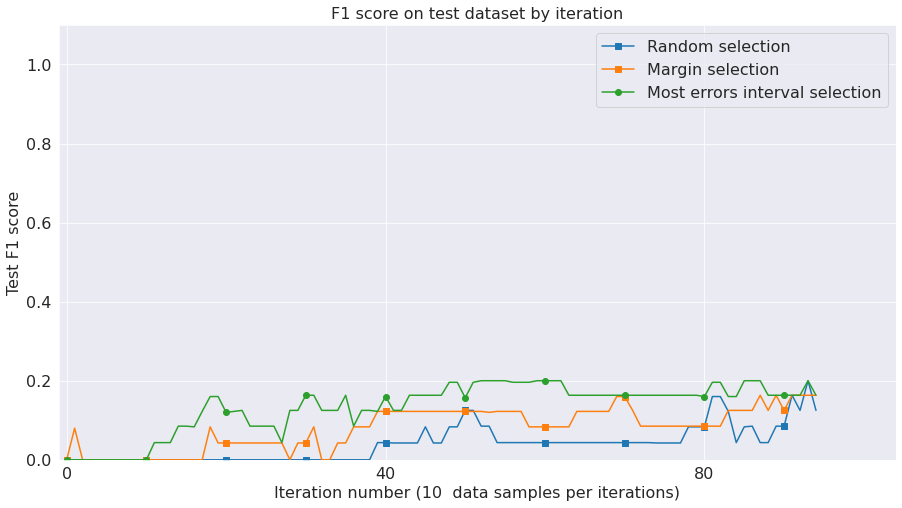

In [52]:
# result plot
import matplotlib.pyplot as plt

BIGGER_SIZE: int = 16
plt.figure(figsize=(15,8))
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title=
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

iterations = np.arange(0, iterations_num+1, 1)

plt.title ("F1 score on test dataset by iteration", fontsize=BIGGER_SIZE)
plt.ylabel("Test F1 score", fontsize=BIGGER_SIZE)
plt.ylim(0,1.1)
plt.xlim(-1,iterations_num+10)
plt.xticks(np.arange(0, iterations_num+1, 40))
plt.yticks(np.arange(0, 1.1, 0.2))
plt.xlabel("Iteration number (10  data samples per iterations)")
plt.plot(iterations, random_cycle.calculated_metrics, label = "Random selection", marker='s', markevery=10)
plt.plot(iterations, margin_cycle.calculated_metrics, label = "Margin selection", marker='s', markevery=10)
plt.plot(iterations, error_bucket_cycle.calculated_metrics, label = "Most errors interval selection", marker='o', markevery=10)
#plt.plot(iterations, embedder_cycle.calculated_metrics, label = "Text similarity selection", marker='o', markevery=10)
plt.legend()
plt.show()
# 14 iteration for margin cycle
# 14 iteration for most error selection
# 20 iteration for embbeder query